# Preprocessing and Modelling #

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
dogs_v_kids = pd.read_csv('../data/dogs_v_kids_cleaned.csv')

## Preprocessing ##

#### Functions for Stemming and Lemmatizing ####

I'll be testing using both **stemming** and **lemmatizing** in my models to see whether or not they improve performance

In [3]:
def stem_words(text):
    # Initialize tokenizer and stemmer
    tokenizer = RegexpTokenizer('\w+')
    stemmer = PorterStemmer()
    
    # Tokenize the text
    words = tokenizer.tokenize(text.lower())
    
    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]
    
    return ' '.join(stemmed_words)
# Adapted from code in lesson 504 as wells as code provided by Katie Sylvia in response to my question about adding stemming to CountVectorizer

In [4]:
def lemm_words(text):
    # Initialize tokenizer and lemmatizer
    tokenizer = RegexpTokenizer('\w+')
    wn = WordNetLemmatizer()
    
    # Create variables
    # wordnet mapper variables taken from lesson 504
    mapper = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    lemmatized_words = []
    
    # Tokenize the text
    words = tokenizer.tokenize(text.lower())
    
    # Position tag the tokenized text
    words_tagged = nltk.pos_tag(words)

    # Lemmatize
    for word, tag in words_tagged:
        pos = mapper.get(tag[0])
        if pos:
            lemmatized_words.append(wn.lemmatize(word, pos))
        else:
            lemmatized_words.append(word)
    
    return ' '.join(lemmatized_words)

I'll use these functions on my corpus, and add the stemmed and lemmatized documents to my dataset:

*Note: I previously attempted to include slightly altered versions of the above **stem_words** and **lemm_words** functions as arguments to the **tokenizer** parameter for **CountVectorizer** in a **GridSearch**. The resulting code was too computationally expensive to be practical (it took hours to run).*

In [5]:
dogs_v_kids['title_post_stemmed'] = [stem_words(doc) for doc in dogs_v_kids['title_post']]
dogs_v_kids['title_post_lemmed'] = [lemm_words(doc) for doc in dogs_v_kids['title_post']]

dogs_v_kids.head()

,subreddit,post,title,author,utc_datetime_str,post_length,post_word_count,title_length,title_word_count,title_post,title_post_stemmed,title_post_lemmed
0,0,"We have a 1 year old maltese shihtzu, we have ...",On lead greetings,M3409,2023-03-02 00:16:11,661,129,17,3,On lead greetings We have a 1 year old maltese...,on lead greet we have a 1 year old maltes shih...,on lead greeting we have a 1 year old maltese ...
1,0,"Color, pile thickness, pattern?\r\n\r\nI have ...",Home carpet recommendations?,GoodMoGo,2023-03-02 00:15:20,326,55,28,3,"Home carpet recommendations? Color, pile thick...",home carpet recommend color pile thick pattern...,home carpet recommendation color pile thicknes...
2,0,"Hello, Noah is a white german shepherd, he has...",Dog epilepsy,kekalam,2023-03-02 00:14:14,376,75,12,2,"Dog epilepsy Hello, Noah is a white german she...",dog epilepsi hello noah is a white german shep...,dog epilepsy hello noah be a white german shep...
3,0,So I’ve moved in to my aunts house and she own...,Advice needed,mfgoodguy,2023-03-02 00:12:16,1037,207,13,2,Advice needed So I’ve moved in to my aunts hou...,advic need so i ve move in to my aunt hous and...,advice need so i ve move in to my aunt house a...
4,0,This is an app that could be useful to find a...,Mappet is an app for dogs lovers,SalvatoreScalia,2023-03-02 00:05:20,308,28,32,7,Mappet is an app for dogs lovers This is an a...,mappet is an app for dog lover thi is an app t...,mappet be an app for dog lover this be an app ...


I'll save out this version of the dataframe:

In [6]:
dogs_v_kids.to_csv('../data/dogs_v_kids_stemmed_n_lemmed.csv', index=False)

#### Function for Tracking Model Performance Metrics ####

In [7]:
def model_stats(model, model_type, vectorizer, transform_type, crutch_words=False):
    # get confusion matrix variables
    if transform_type == 'o':
        y_hat = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    elif transform_type == 'l':
        y_hat = model.predict(X_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l, y_hat).ravel()
    else:
        y_hat = model.predict(X_test_s)
        tn, fp, fn, tp = confusion_matrix(y_test_s, y_hat).ravel()
    
    # get training accuracy scores
    if transform_type == 'o':
        train_accuracy = model.score(X_train, y_train)
    elif transform_type == 'l':
        train_accuracy = model.score(X_train_l, y_train_l)
    else:
        train_accuracy = model.score(X_train_s, y_train_s)
    
    # store various model stats as a library
    stats = {
        'model_type': model_type,
        'vectorizer': vectorizer,
        'transform_type': transform_type,
        'crutch_words_removed': crutch_words * 1,  
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'train_accuracy': train_accuracy,
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'sensitivity': tp / (tp + fn),
        'specificity': tn / (tn + fp),
        'precision': tp / (tp + fp)
    }
    
    return stats

I'll also create a variable to store them

In [8]:
model_metrics = []

#### Custom Stop Words - Crutch Words ####

I'm going to define a custom class of stop words that I'll call **'Crutch Words'**. This list includes some of the most popular and obvious differentiator words from each subreddit, such as 'dog' and 'kids'. I'll do versions of each model with and without the list of **'Crutch Words'**.

I expect removing the **'Crutch Words'** to negatively impact model performance, but I am interested to see to what extent that is the case

In [9]:
crutch_words = ['dog', 'dogs', 'puppy', 'vet', 'kid', 'kids', 'son', 'daughter', 'baby']
crutch_words_eng = stopwords.words('english') + crutch_words
print(crutch_words_eng)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

I'll run my **stemming** and **lemmatizing** functions over the stop words lists as well, for use with my **stemmed** and **lemmatized** corpora:

In [10]:
eng_stopwords_stemmed = stem_words(' '.join(stopwords.words('english'))).split()
eng_stopwords_lemmed = lemm_words(' '.join(stopwords.words('english'))).split()
crutch_words_stemmed = stem_words(' '.join(crutch_words_eng)).split()
crutch_words_lemmed = lemm_words(' '.join(crutch_words_eng)).split()

#### Defining X and y Variables ####

I'm going to define three different versions of X: one each for my **original**, **stemmed**, and **lemmatized** corpora

In [11]:
X = dogs_v_kids['title_post']
X_s = dogs_v_kids['title_post_stemmed']
X_l = dogs_v_kids['title_post_lemmed']

y = dogs_v_kids['subreddit']

#### Train/Test Split ####

Likewise, I'll do a train/test split for each version of X

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1234)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1234)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1234)

## Modelling ##

I'll build four different types of models:
1) Logistic Regression
2) Random Forest
3) Gradient Boost
4) Support Vector Machine

For each model type I'll build two sets of models:
1) The first set will be given the corpus of data with the **'Crutch Words'** still included
2) The second will be given data with the **'Crutch Words'** removed

For each model I'll use **GridSearch** to determine best parameters

##### Baseline Score #####

In [13]:
pd.DataFrame(y.value_counts(normalize=True))

,subreddit
0,0.529465
1,0.470535


<font size='2'>*Recall that 0 represents **r/dogs**, while 1 represents the target value, **r/parenting***<font>

### 1. Logistic Regression ###

I'll run four **Logistic Regression** models each on the data with and without **crutch words**. For the first three I'll transform each of the three versions of the corpus with **CountVectorizer**:
1) Original Corpus
2) Stemmed Corpus
3) Lemmatized Corpus

For the fourth model I'll transform the data using **TfidfVectorizer**, using the version of the corpus that performed best among the first three.

#### 1.a.1 Crutch Words Allowed - CountVectorizer - Original Corpus ####

##### Model Instantiation and Fitting #####

In [14]:
log_o_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [15]:
log_o_pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [3,4,5],
    'cvec__max_df': [0.7, 0.75, 0.8],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': ['english'],
    'logreg__C': [0.1, 0.05, 0.02],
    'logreg__n_jobs': [4]
}

In [16]:
log_o_gs = GridSearchCV(log_o_pipe,
                      param_grid = log_o_pipe_params,
                      cv = 5)

In [17]:
log_o_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.7, 0.75, 0.8],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [3, 4, 5],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english'],
                         'logreg__C': [0.1, 0.05, 0.02],
                         'logreg__n_jobs': [4]})

##### Best Parameters #####

In [18]:
log_o_gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'logreg__C': 0.05,
 'logreg__n_jobs': 4}

##### Model Performance Metrics #####

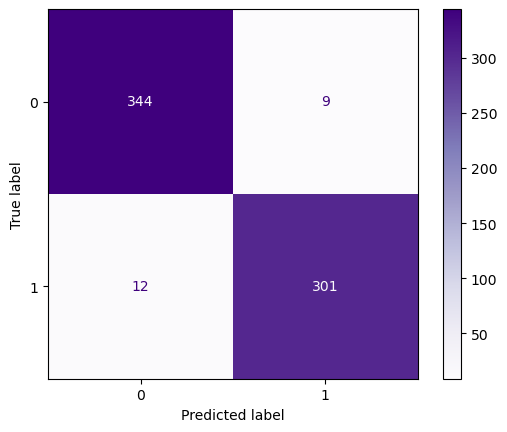

In [19]:
ConfusionMatrixDisplay.from_estimator(log_o_gs, X_test, y_test, cmap = 'Purples');

In [20]:
log_o_metrics = model_stats(log_o_gs, 'log', 'c', 'o')
model_metrics.append(log_o_metrics)
pd.DataFrame(log_o_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.992857,0.968468,0.961661


##### Model Performance Summary #####
This is the first model I've run, and with only the baseline to compare it to it looks like a pretty performative model. The testing **accuracy** score of .968 is well above the baseline score of .529.

**Sensitivity** is the performance metric I'm most interested in. I'll need to wait until I have other models to compare to, but a **sensitivity** score of .962 seems like a pretty good start

#### 1.a.2. Crutch Words Allowed - CountVectorizer - Stemmed Corpus ####

##### Model Instantiation and Fitting #####

In [21]:
log_s_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [22]:
log_s_pipe_params = {
    'cvec__max_features': [3000, 3500, 4000],
    'cvec__min_df': [2,3,4],
    'cvec__max_df': [0.45, 0.5, 0.55],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [eng_stopwords_stemmed],
    'logreg__C': [0.05, 0.025, 0.01],
    'logreg__n_jobs': [4]
}

In [23]:
log_s_gs = GridSearchCV(log_s_pipe,
                      param_grid = log_s_pipe_params,
                      cv = 5)

In [24]:
log_s_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.45, 0.5, 0.55],
                         'cvec__max_features': [3000, 3500, 4000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]],
                         'logreg__C': [0.05, 0.025, 0.01],
                         'logreg__n_jobs': [4]})

##### Best Parameters #####

In [25]:
log_s_gs.best_params_.pop('cvec__stop_words')
log_s_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 3000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 0.025,
 'logreg__n_jobs': 4}

##### Model Performance Metrics #####

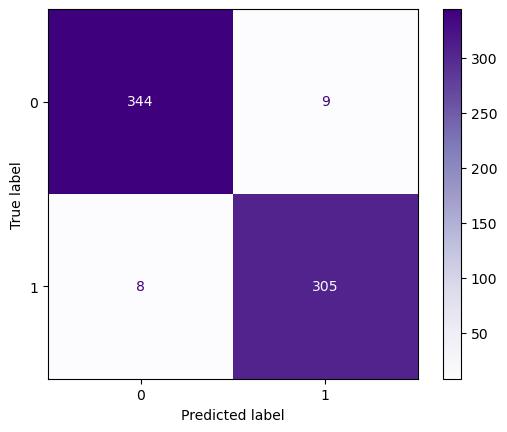

In [26]:
ConfusionMatrixDisplay.from_estimator(log_s_gs, X_test_s, y_test_s, cmap = 'Purples');

In [27]:
log_s_metrics = model_stats(log_s_gs, 'log', 'c', 's')
model_metrics.append(log_s_metrics)
pd.DataFrame(log_s_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.993233,0.974474,0.974441


##### Model Performance Summary #####
Stemming the corpus does appear to result in a boost inperformance. Our **accuracy** score improves to .974, compared to .968 from the model run without stemming. **Sensitivity** also gets a boost from from .962 to .974

#### 1.a.3. Crutch Words Allowed - CountVectorizer - Lemmatized Corpus ####

##### Model Instantiation and Fitting #####

In [28]:
log_l_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [29]:
log_l_pipe_params = {
    'cvec__max_features': [4000, 4500, 5000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.45, 0.5, 0.55],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [eng_stopwords_lemmed],
    'logreg__C': [0.05, 0.025, 0.01],
    'logreg__n_jobs': [4]
}

In [30]:
log_l_gs = GridSearchCV(log_l_pipe,
                      param_grid = log_l_pipe_params,
                      cv = 5)

In [31]:
log_l_gs.fit(X_train_l, y_train_l)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.45, 0.5, 0.55],
                         'cvec__max_features': [4000, 4500, 5000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', 'you', 're', 'you', 've',
                                               'you', 'll', 'you', 'd', 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', 'she', 's',
                                               'her', 'hers', ...]],
                         'logreg__C': [0.05, 0.025, 0.01],
                         'logreg__n_jobs': [4]})

##### Best Parameters #####

In [32]:
log_l_gs.best_params_.pop('cvec__stop_words')
log_l_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 4500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 0.025,
 'logreg__n_jobs': 4}

##### Model Performance Metrics #####

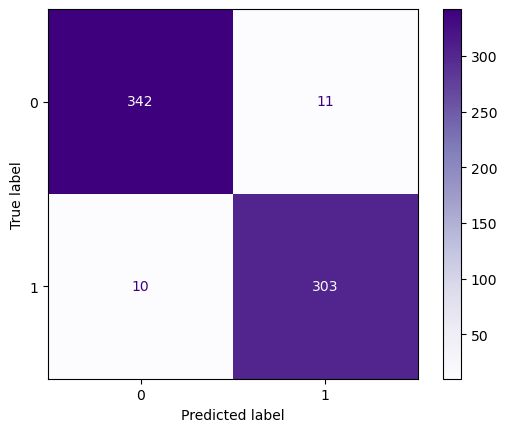

In [33]:
ConfusionMatrixDisplay.from_estimator(log_l_gs, X_test_l, y_test_l, cmap = 'Purples');

In [34]:
log_l_metrics = model_stats(log_l_gs, 'log', 'c', 'l')
model_metrics.append(log_l_metrics)
pd.DataFrame(log_l_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.993233,0.968468,0.968051


##### Model Performance Summary #####
Performance on the model for the **lemmatized** corpus falls between that of the model on the **stemmed** corpus and the **original**. Both **accuracy** and **sensitivity** scores fall in the middle of the three.

The model on the **stemmed** corpus appears to be the best performer

#### 1.a.4. Crutch Words Allowed - TfidfVectorizer - Stemmed Corpus ####

The model on the **stemmed** corpus performed best of the previous three models, so that's what I will use for the **TfidfVectorizer** model 

##### Model Instantiation and Fitting #####

In [35]:
log_st_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [36]:
log_st_pipe_params = {
    'tvec__max_features': [1500, 2000, 2500],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.4, 0.5, 0.55],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [eng_stopwords_stemmed],
    'logreg__C': [0.08, 0.1, 0.3, 0.5],
    'logreg__n_jobs': [4]
}

In [37]:
log_st_gs = GridSearchCV(log_st_pipe,
                      param_grid = log_st_pipe_params,
                      cv = 5)

In [38]:
log_st_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.08, 0.1, 0.3, 0.5],
                         'logreg__n_jobs': [4],
                         'tvec__max_df': [0.4, 0.5, 0.55],
                         'tvec__max_features': [1500, 2000, 2500],
                         'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [39]:
log_st_gs.best_params_.pop('tvec__stop_words')
log_st_gs.best_params_

{'logreg__C': 0.3,
 'logreg__n_jobs': 4,
 'tvec__max_df': 0.5,
 'tvec__max_features': 2500,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

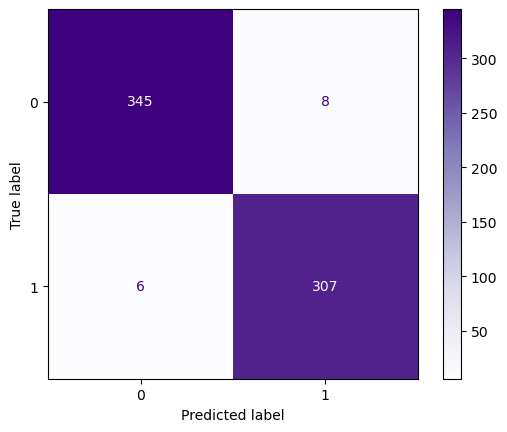

In [40]:
ConfusionMatrixDisplay.from_estimator(log_st_gs, X_test_s, y_test_s, cmap = 'Purples');

In [41]:
log_st_metrics = model_stats(log_st_gs, 'log', 't', 's')
model_metrics.append(log_st_metrics)
pd.DataFrame(log_st_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.989474,0.978979,0.980831


##### Model Performance Summary #####
The **TfidfVectorizer** does appear to provide a performance boost over the **CountVectorizer**. Our **accuracy** score is up to .979, and our **sensitivity** is up to .981, with only 6 false negatives predictions on the test data

#### 1.b.1. Crutch Words Removed - CountVectorizer - Original Corpus ####

##### Model Instantiation and Fitting #####

In [42]:
log_oc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [43]:
log_oc_pipe_params = {
    'cvec__max_features': [4000, 5000, 6000],
    'cvec__min_df': [3, 4, 5],
    'cvec__max_df': [0.6, 0.65, 0.7],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [crutch_words_eng],
    'logreg__C': [0.5, 0.25, 0.1],
    'logreg__n_jobs': [4]
}

In [44]:
log_oc_gs = GridSearchCV(log_oc_pipe,
                      param_grid = log_oc_pipe_params,
                      cv = 5)

In [45]:
log_oc_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.6, 0.65, 0.7],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [3, 4, 5],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'logreg__C': [0.5, 0.25, 0.1], 'logreg__n_jobs': [4]})

##### Best Parameters #####

In [46]:
log_oc_gs.best_params_.pop('cvec__stop_words')
log_oc_gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__max_features': 6000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 0.1,
 'logreg__n_jobs': 4}

##### Model Performance Metrics #####

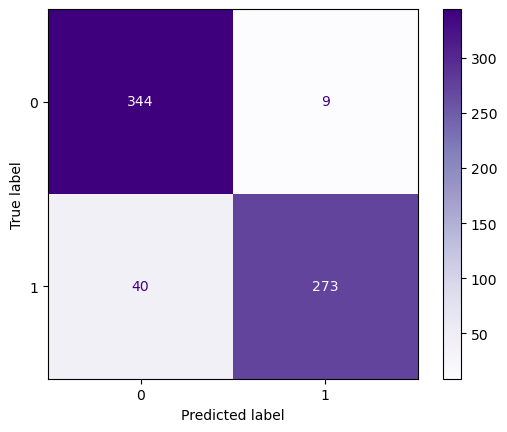

In [47]:
ConfusionMatrixDisplay.from_estimator(log_oc_gs, X_test, y_test, cmap = 'Purples');

In [48]:
log_oc_metrics = model_stats(log_oc_gs, 'log', 'c', 'o', crutch_words=True)
model_metrics.append(log_oc_metrics)
pd.DataFrame(log_oc_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.991729,0.926426,0.872204


##### Model Performance Summary #####

While this model is still a strong improvement from the baseline, comparing to the previous logistic regression models shows a very marked negative impact on model performance from the removal of the **crutch words**.

Worse still, much of the drop in performance is along the metric we care most about, **sensitivity**. This model produced almost four times as many false negatives on the test set as the comparable model without **crutch words** removed.

The **variance** on this model is also high compared to the models with **crutch words** allowed. Interestingly, the best value for the regularization parameter **C** chosen by **GridSearch** was relatively high. It might be possible to eke a little more performance out of this model by honing in further on that parameter.

Clearly, removing the **crutch words** imparts a significant handicap on model performance

#### 1.b.2. Crutch Words Removed - CountVectorizer - Stemmed Corpus ####

##### Model Instantiation and Fitting #####

In [49]:
log_sc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [50]:
log_sc_pipe_params = {
    'cvec__max_features': [5000, 6000, 7000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.5, 0.55, 0.6],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [crutch_words_stemmed],
    'logreg__C': [0.7, 0.6, 0.5, 0.4],
    'logreg__n_jobs': [4]
}

In [51]:
log_sc_gs = GridSearchCV(log_sc_pipe,
                      param_grid = log_sc_pipe_params,
                      cv = 5)

In [52]:
log_sc_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.5, 0.55, 0.6],
                         'cvec__max_features': [5000, 6000, 7000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]],
                         'logreg__C': [0.7, 0.6, 0.5, 0.4],
                         'logreg__n_jobs': [4]})

##### Best Parameters #####

In [53]:
log_sc_gs.best_params_.pop('cvec__stop_words')
log_sc_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 6000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 0.5,
 'logreg__n_jobs': 4}

##### Model Performance Metrics #####

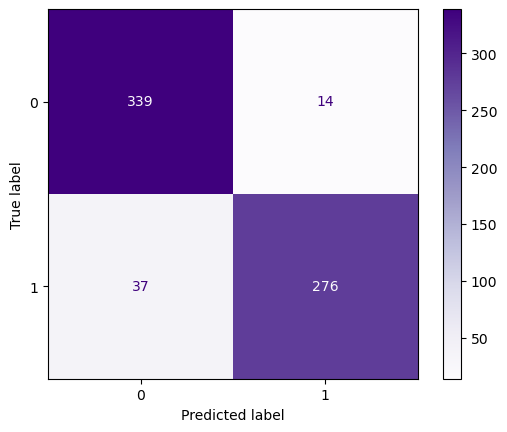

In [54]:
ConfusionMatrixDisplay.from_estimator(log_sc_gs, X_test_s, y_test_s, cmap = 'Purples');

In [55]:
log_sc_metrics = model_stats(log_sc_gs, 'log', 'c', 's', crutch_words=True)
model_metrics.append(log_sc_metrics)
pd.DataFrame(log_sc_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,1.0,0.923423,0.881789


##### Model Performance Summary #####
As with the **crutch words allowed** models, we get a minor performance boost from **stemming** our corpus. The **sensitivity** of .882 is an improvement on the previous model, but still very low in comparison to the models that have not been handicapped with the **crutch words** list

As with the previous model, we're looking at pretty high **variance** between train and test **accuracy**, but with the **GridSearch** returning a middle-of-the-road regulation parameter as the best parameter

#### 1.b.3. Crutch Words Removed - CountVectorizer - Lemmatized Corpus ####

##### Model Instantiation and Fitting #####

In [56]:
log_lc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [57]:
log_lc_pipe_params = {
    'cvec__max_features': [3500, 4000, 4500],
    'cvec__min_df': [2,3,4],
    'cvec__max_df': [0.4, 0.45, 0.5],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [crutch_words_lemmed],
    'logreg__C': [0.04, 0.05, 0.06],
    'logreg__n_jobs': [4]
}

In [58]:
log_lc_gs = GridSearchCV(log_lc_pipe,
                      param_grid = log_lc_pipe_params,
                      cv = 5)

In [59]:
log_lc_gs.fit(X_train_l, y_train_l)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.4, 0.45, 0.5],
                         'cvec__max_features': [3500, 4000, 4500],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', 'you', 're', 'you', 've',
                                               'you', 'll', 'you', 'd', 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', 'she', 's',
                                               'her', 'hers', ...]],
                         'logreg__C': [0.04, 0.05, 0.06],
                         'logreg__n_jobs': [4]})

##### Best Parameters #####

In [60]:
log_lc_gs.best_params_.pop('cvec__stop_words')
log_lc_gs.best_params_

{'cvec__max_df': 0.4,
 'cvec__max_features': 4500,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 0.06,
 'logreg__n_jobs': 4}

##### Model Performance Metrics #####

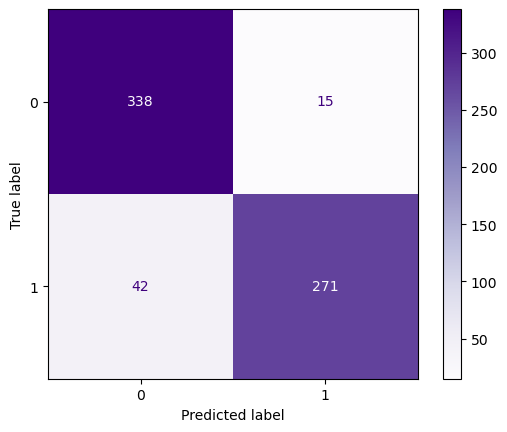

In [61]:
ConfusionMatrixDisplay.from_estimator(log_lc_gs, X_test_l, y_test_l, cmap = 'Purples');

In [62]:
log_lc_metrics = model_stats(log_lc_gs, 'log', 'c', 'l', crutch_words=True)
model_metrics.append(log_lc_metrics)
pd.DataFrame(log_lc_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.983835,0.914414,0.865815


##### Model Performance Summary #####
The model on the **lemmatized** corpus is the worst performer of the three **CountVectorizer** models with **crutch words** removed. It scores lower even than the model on the original corpus on both **accuracy** and **sensitivity**.

As with the **crutch words allowed** set of **Logistic Regression** models, **stemming** the corpus appears to produce the best performing model

#### 1.b.4. Crutch Words Removed - TfidfVectorizer - Stemmed Corpus ####

##### Model Instantiation and Fitting #####

In [63]:
log_stc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [64]:
log_stc_pipe_params = {
    'tvec__max_features': [4000, 4500, 5000],
    'tvec__min_df': [3, 4, 5],
    'tvec__max_df': [0.2, 0.25, 0.3],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [crutch_words_stemmed],
    'logreg__C': [0.6, 0.7],
    'logreg__n_jobs': [4]
}

In [65]:
log_stc_gs = GridSearchCV(log_stc_pipe,
                      param_grid = log_stc_pipe_params,
                      cv = 5)

In [66]:
log_stc_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.6, 0.7], 'logreg__n_jobs': [4],
                         'tvec__max_df': [0.2, 0.25, 0.3],
                         'tvec__max_features': [4000, 4500, 5000],
                         'tvec__min_df': [3, 4, 5],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [67]:
log_stc_gs.best_params_.pop('tvec__stop_words')
log_stc_gs.best_params_

{'logreg__C': 0.7,
 'logreg__n_jobs': 4,
 'tvec__max_df': 0.3,
 'tvec__max_features': 5000,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

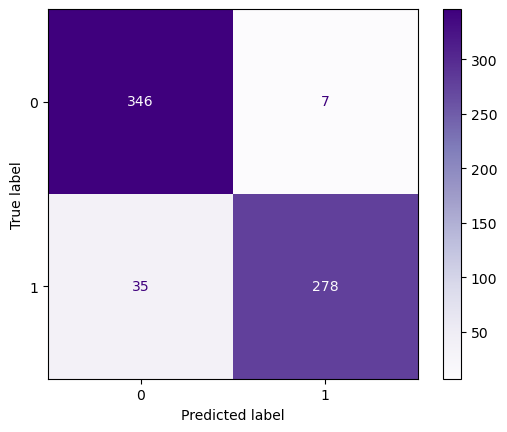

In [68]:
ConfusionMatrixDisplay.from_estimator(log_stc_gs, X_test_s, y_test_s, cmap = 'Purples');

In [69]:
log_stc_metrics = model_stats(log_stc_gs, 'log', 't', 's', crutch_words=True)
model_metrics.append(log_stc_metrics)
pd.DataFrame(log_stc_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.972556,0.936937,0.888179


##### Model Performance #####
The **TfidfVectorizer** also gives a small performance boost over **CountVectorizer** to the models with **crutch words** removed, with a slightly better **accuracy** score on the test data, as well as a small improvement to **sensitivity**.

Notably, the **variance** is significantly lower than the models with **CountVectorizer**.

### 2. Random Forest ###

For my **Random Forest** models, and going forward, I will only run one model each with and without **crutch words**, using the transformation technique and vectorizer that produced the best results on my **Logistic Regression** models. 

As **stemming** and **TfidfVectorizer** produced the best results, those are what I will use going forward

#### 2.a. Crutch Words Allowed ####

##### Model Instantiation and Fitting #####

In [70]:
rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [71]:
rf_pipe_params = {
    'tvec__max_features': [2000, 2500],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [0.45, 0.5],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [eng_stopwords_stemmed],
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [None, 7],
    'rf__n_jobs': [4]
}

In [72]:
rf_gs = GridSearchCV(rf_pipe,
                      param_grid = rf_pipe_params,
                      cv = 5)

In [73]:
rf_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 7],
                         'rf__n_estimators': [100, 150], 'rf__n_jobs': [4],
                         'tvec__max_df': [0.45, 0.5],
                         'tvec__max_features': [2000, 2500],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [74]:
rf_gs.best_params_.pop('tvec__stop_words')
rf_gs.best_params_

{'rf__max_depth': None,
 'rf__n_estimators': 100,
 'rf__n_jobs': 4,
 'tvec__max_df': 0.5,
 'tvec__max_features': 2000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

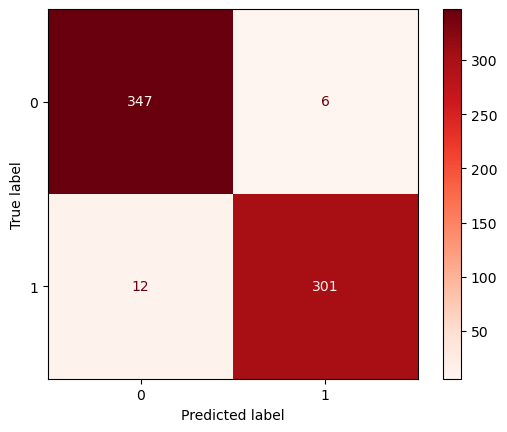

In [75]:
ConfusionMatrixDisplay.from_estimator(rf_gs, X_test_s, y_test_s, cmap = 'Reds');

In [76]:
rf_metrics = model_stats(rf_gs, 'rf', 't', 's')
model_metrics.append(rf_metrics)
pd.DataFrame(rf_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,1.0,0.972973,0.961661


##### Model Performance Summary #####
The **Random Forest** model slightly underperformed compared to the best **Logistic Regression** model, with an **accuracy** score of .973, compared to .979 for **Logistic Regression**.

**Random Forest** also does not appear to be quite as well optimized for **sensitivity**, with a lower score of .962 (vs .981 for **Logistic Regression**)

#### 2.b. Crutch Words Removed ####

##### Model Instantiation and Fitting #####

In [77]:
rf_c_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [78]:
rf_c_pipe_params = {
    'tvec__max_features': [4000, 5000, 6000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.25, 0.3, 0.35],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [crutch_words_stemmed],
    'rf__n_estimators': [150, 200, 250],
    'rf__min_samples_leaf': [1],
    'rf__n_jobs': [4]
}

In [79]:
rf_c_gs = GridSearchCV(rf_c_pipe,
                      param_grid = rf_c_pipe_params,
                      cv = 5)

In [80]:
rf_c_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__min_samples_leaf': [1],
                         'rf__n_estimators': [150, 200, 250], 'rf__n_jobs': [4],
                         'tvec__max_df': [0.25, 0.3, 0.35],
                         'tvec__max_features': [4000, 5000, 6000],
                         'tvec__min_df': [1, 2], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [81]:
rf_c_gs.best_params_.pop('tvec__stop_words')
rf_c_gs.best_params_

{'rf__min_samples_leaf': 1,
 'rf__n_estimators': 250,
 'rf__n_jobs': 4,
 'tvec__max_df': 0.3,
 'tvec__max_features': 6000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

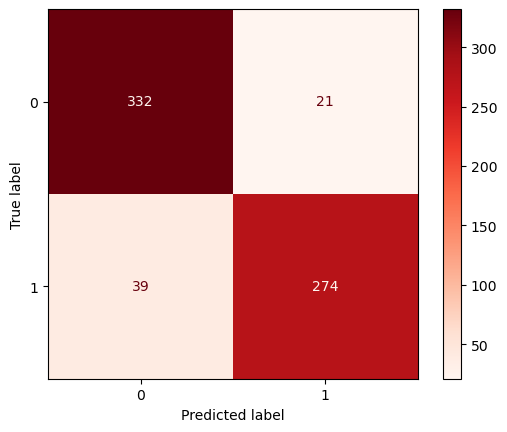

In [82]:
ConfusionMatrixDisplay.from_estimator(rf_c_gs, X_test_s, y_test_s, cmap = 'Reds');

In [83]:
rf_c_metrics = model_stats(rf_c_gs, 'rf', 't', 's', crutch_words=True)
model_metrics.append(rf_c_metrics)
pd.DataFrame(rf_c_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,1.0,0.90991,0.875399


##### Model Performance #####
It's interesting to see some pretty different results between the two **Random Forest** models. The model on the **crutch words allowed** data, when compared to **Logistic Regression**, saw similar performance on **accuracy**, but saw decreased performance along the **sensitivity** metric.

The **Random Forest** model with **crutch words** removed, by contrast, had decreased performance on **accuracy** compared to **Logistic Regression**, but performed similarly on the **sensitivity** metric.

### 3. Gradient Boost ###

#### 3.a. Crutch Words Allowed ####

##### Model Instantiation and Fitting #####

In [84]:
gb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

In [85]:
gb_pipe_params = {
    'tvec__max_features': [1500, 2000, 2500],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [0.5, 0.6, 0.7],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [eng_stopwords_stemmed],
    'gb__n_estimators': [150, 200],
    'gb__max_depth': [1, 2],
    'gb__learning_rate': [0.1, 1]
}

In [86]:
gb_gs = GridSearchCV(gb_pipe,
                      param_grid = gb_pipe_params,
                      cv = 5)

In [87]:
gb_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('gb', GradientBoostingClassifier())]),
             param_grid={'gb__learning_rate': [0.1, 1], 'gb__max_depth': [1, 2],
                         'gb__n_estimators': [150, 200],
                         'tvec__max_df': [0.5, 0.6, 0.7],
                         'tvec__max_features': [1500, 2000, 2500],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [88]:
gb_gs.best_params_.pop('tvec__stop_words')
gb_gs.best_params_

{'gb__learning_rate': 0.1,
 'gb__max_depth': 2,
 'gb__n_estimators': 150,
 'tvec__max_df': 0.7,
 'tvec__max_features': 2500,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

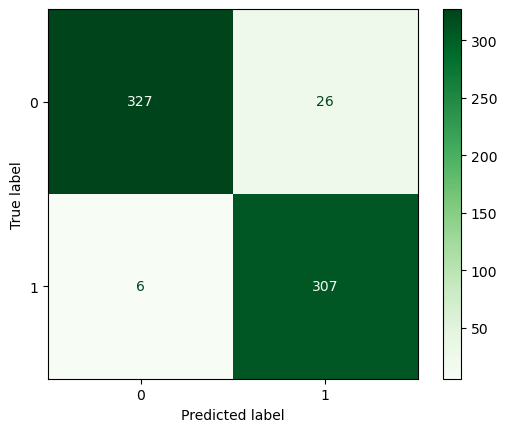

In [89]:
ConfusionMatrixDisplay.from_estimator(gb_gs, X_test_s, y_test_s, cmap = 'Greens');

In [90]:
gb_metrics = model_stats(gb_gs, 'gb', 't', 's')
model_metrics.append(gb_metrics)
pd.DataFrame(gb_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.980827,0.951952,0.980831


##### Model Performance Summary #####
The  **Gradient Boost** model had a lower test **accuracy** score than other models. It's score of .952 does not place it among the stronger performers. The top **Logistic Regression** model, still leading in this metric, came in at .979.

However, basically all of that lost performance is in the direction of false positives. In fact, with a **sensitivity** of .981, **Gradient Boost** is thus far the model best optimized for that metric.

#### 3.b. Crutch Words Removed ####

##### Model Instantiation and Fitting #####

In [91]:
gb_c_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

In [92]:
gb_c_pipe_params = {
    'tvec__max_features': [2000],
    'tvec__min_df': [1],
    'tvec__max_df': [0.3],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [crutch_words_stemmed],
    'gb__n_estimators': [300, 350, 400, 500],
    'gb__max_depth': [3, 4, 5],
    'gb__learning_rate': [0.1]
}

In [93]:
gb_c_gs = GridSearchCV(gb_c_pipe,
                      param_grid = gb_c_pipe_params,
                      cv = 5)

In [94]:
gb_c_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('gb', GradientBoostingClassifier())]),
             param_grid={'gb__learning_rate': [0.1], 'gb__max_depth': [3, 4, 5],
                         'gb__n_estimators': [300, 350, 400, 500],
                         'tvec__max_df': [0.3], 'tvec__max_features': [2000],
                         'tvec__min_df': [1], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [95]:
gb_c_gs.best_params_.pop('tvec__stop_words')
gb_c_gs.best_params_

{'gb__learning_rate': 0.1,
 'gb__max_depth': 3,
 'gb__n_estimators': 500,
 'tvec__max_df': 0.3,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

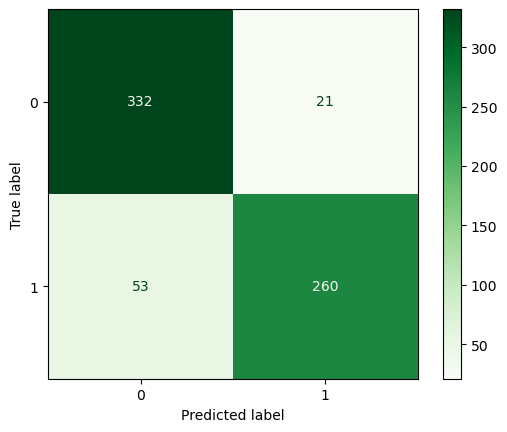

In [96]:
ConfusionMatrixDisplay.from_estimator(gb_c_gs, X_test_s, y_test_s, cmap = 'Greens');

In [97]:
gb_c_metrics = model_stats(gb_c_gs, 'gb', 't', 's', crutch_words=True)
model_metrics.append(gb_c_metrics)
pd.DataFrame(gb_c_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,1.0,0.888889,0.830671


##### Model Performance Summary #####
**Gradient Boost** turns out to be the worst performing model with **crutch words** removed. **Accuracy** scores are bottom of the barrel. Worse, that loss in performance manifests disproportionately as increased false negatives, leading to **sensitivity** of .837, by far the lowest of all models attempted

### Support Vector Machine ###

#### 4.a. Crutch Words Allowed ####

##### Model Instantiation and Fitting #####

In [98]:
svc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [99]:
svc_pipe_params ={
    'tvec__max_features': [3500, 4000, 4500],
    'tvec__min_df': [7, 8],
    'tvec__max_df': [0.5, 0.6, 0.7],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [eng_stopwords_stemmed],
    'svc__C': [1.448793103448276],
    'svc__kernel': ['rbf']
}

In [100]:
svc_gs = GridSearchCV(svc_pipe,
                      param_grid = svc_pipe_params,
                      cv = 5)

In [101]:
svc_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1.448793103448276], 'svc__kernel': ['rbf'],
                         'tvec__max_df': [0.5, 0.6, 0.7],
                         'tvec__max_features': [3500, 4000, 4500],
                         'tvec__min_df': [7, 8], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [102]:
svc_gs.best_params_.pop('tvec__stop_words')
svc_gs.best_params_

{'svc__C': 1.448793103448276,
 'svc__kernel': 'rbf',
 'tvec__max_df': 0.5,
 'tvec__max_features': 4000,
 'tvec__min_df': 7,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

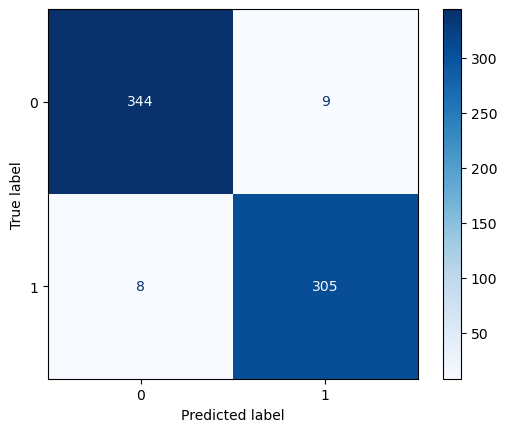

In [103]:
ConfusionMatrixDisplay.from_estimator(svc_gs, X_test_s, y_test_s, cmap = 'Blues');

In [104]:
svc_metrics = model_stats(svc_gs, 'svm', 't', 's')
model_metrics.append(svc_metrics)
pd.DataFrame(svc_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,0.999624,0.974474,0.974441


##### Model Performance Summary #####
The  **Support Vector Machine** model is a strong performer, but not the best:

**Accuracy** score is very solid at .974, but **Logistic Regression's accuracy**  score is still tops at .979.

The **sensitivity** of .974 is, again, pretty good, but is bested by **Gradiant Boost** at .981

#### 4.b. Crutch Words Removed ####

##### Model Instantiation and Fitting #####

In [105]:
svc_c_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [106]:
svc_c_pipe_params = {
    'tvec__max_features': [4000, 4500, 5000, 6000],
    'tvec__min_df': [4, 5, 6],
    'tvec__max_df': [0.2, 0.25, 0.3],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [crutch_words_stemmed],
    'svc__C': [1.9658620689655173],
    'svc__kernel': ['rbf']
}

In [107]:
svc_c_gs = GridSearchCV(svc_c_pipe,
                      param_grid = svc_c_pipe_params,
                      cv = 5)

In [108]:
svc_c_gs.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1.9658620689655173], 'svc__kernel': ['rbf'],
                         'tvec__max_df': [0.2, 0.25, 0.3],
                         'tvec__max_features': [4000, 4500, 5000, 6000],
                         'tvec__min_df': [4, 5, 6],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'our', 'ourselv', 'you',
                                               'you', 're', 'you', 've', 'you',
                                               'll', 'you', 'd', 'your', 'your',
                                               'yourself', 'yourselv', 'he',
                                               'him', 'hi', 'himself', 'she',
                                               'she', 's', 'her', 'her', ...]]})

##### Best Parameters #####

In [109]:
svc_c_gs.best_params_.pop('tvec__stop_words')
svc_c_gs.best_params_

{'svc__C': 1.9658620689655173,
 'svc__kernel': 'rbf',
 'tvec__max_df': 0.3,
 'tvec__max_features': 4500,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2)}

##### Model Performance Metrics #####

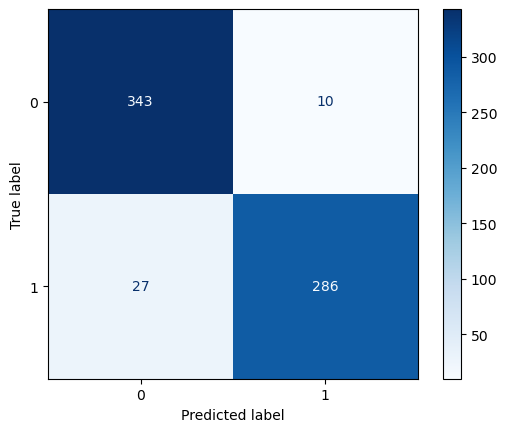

In [110]:
ConfusionMatrixDisplay.from_estimator(svc_c_gs, X_test_s, y_test_s, cmap = 'Blues');

In [111]:
svc_c_metrics = model_stats(svc_c_gs, 'svm', 't', 's', crutch_words=True)
model_metrics.append(svc_c_metrics)
pd.DataFrame(svc_c_metrics, index=[0])[['train_accuracy', 'accuracy','sensitivity']]

,train_accuracy,accuracy,sensitivity
0,1.0,0.944444,0.913738


##### Model Performance Summary #####
**Support Vector Machine** turns out to be by far the most performative model with **crutch words** removed. The **accuracy** score of .944 on the test data, and **sensitivity** of .914 both best all other **crutch words** removed models by significant margins.

In [112]:
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.to_csv('../data/model_performance_metrics.csv', index=False)
model_metrics_df

,model_type,vectorizer,transform_type,crutch_words_removed,true_positives,true_negatives,false_positives,false_negatives,train_accuracy,accuracy,sensitivity,specificity,precision
0,log,c,o,0,301,344,9,12,0.992857,0.968468,0.961661,0.974504,0.970968
1,log,c,s,0,305,344,9,8,0.993233,0.974474,0.974441,0.974504,0.971338
2,log,c,l,0,303,342,11,10,0.993233,0.968468,0.968051,0.968839,0.964968
3,log,t,s,0,307,345,8,6,0.989474,0.978979,0.980831,0.977337,0.974603
4,log,c,o,1,273,344,9,40,0.991729,0.926426,0.872204,0.974504,0.968085
5,log,c,s,1,276,339,14,37,1.000000,0.923423,0.881789,0.960340,0.951724
6,log,c,l,1,271,338,15,42,0.983835,0.914414,0.865815,0.957507,0.947552
7,log,t,s,1,278,346,7,35,0.972556,0.936937,0.888179,0.980170,0.975439
8,rf,t,s,0,301,347,6,12,1.000000,0.972973,0.961661,0.983003,0.980456
9,rf,t,s,1,274,332,21,39,1.000000,0.909910,0.875399,0.940510,0.928814
